#  Reinforcement Learning Fundamentals and Q-Learning

This notebook contains the live code demo for the module *Part 1 : Reinforcement Learning Fundamentals, Q Learning*. Here we cover four things:
- **Introduction to Gymnasium:** Gymnasium (formerly OpenAI Gym) is a popular toolkit for testing Reinforcement Learning algorithms. We will introduce the Blackjack environment here and develop an intuition for the structure of RL environments.
- **Computing a Blackjack policy using a Markov Decision Process model:** Here we will compute an optimal strategy for playing the Blackjack environment by solving a Markov Decision Process. Markov Decision Processes are the basis for the various Reinforcement Learning algorithms we will see later. Part of our aim is to demonstate that finding a strategy by solving the MDP is a bit tedious; it requires specifying a complete model of the mechanics of Blackjack before we can compute our strategy.
- **Computing a Blackjack policy using Q-learning:** Here we will compute a strategy for playing the Blackjack environment using tabular Q-learning. Here we do not need to know a model for the environment. Instead, we interact with the environment and learn our strategy as we play the game.
- **Computing a Blackjack policy using Deep Q-learning:** Here we will compute a strategy for playing the Blackjack environment using Deep Q-learning. This works similarly to tabular Q-learning, although we will use a neural network to approximate the Q function rather than computing Q values in a table. Several additional modifications need to be made to the algorithm to ensure that it remains stable.

In [ ]:
# First we will install the Gymnasium package
#!pip install gymnasium
#!pip install pygame

In [2]:
import gymnasium as gym
import torch
import torch.nn.functional as F

import random
import numpy as np
from IPython import display
from collections import deque, OrderedDict
import matplotlib.pyplot as plt

---
### The Blackjack Gymnasium environment

[Gymnasium](https://gymnasium.farama.org/) (formerly OpenAI Gym) is a popular toolkit for testing reinforcement learning algorithms. It provides simulation environments for a variety of RL tasks and a simple common interface for interacting the environments. In this notebook we will work with the [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/) environment, which plays the popular casino game Blackjack. We will introduce the basic mechanics of the Gymnasium Blackjack environment by manually playing a hand.

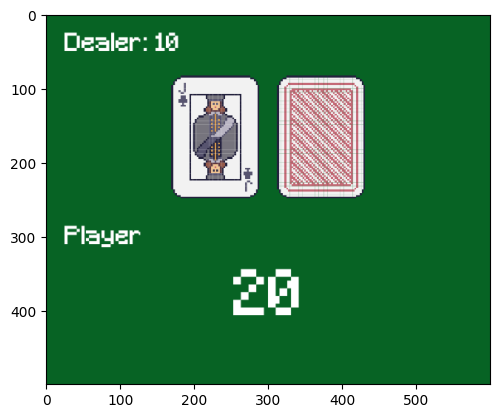

(20, 10, 0) 1.0 True False {}


In [5]:
"""
Here we interact directly with the Blackjack environment to get
a feel for how it works
"""

# Create the environment
env = gym.make("Blackjack-v1", render_mode="rgb_array")

# Deal the cards / sample an initial state
obs = env.reset()[0]

# Render a visualization in the notebook
plt.imshow(env.render())
plt.show()
print(obs)

# Loop as long as the hand has not finished
done = False
while not done:

    # Choose an action: 1 is hit, 0 is stand
    action = int(input("Hit (1) / Stand (0): "))

    # Provide the action to the environment and update the game state
    # The environment returns three values that we care about:
    # - obs: The current state (or "observation", equivalent in this case)
    # - reward: The reward earned in the current step
    # - done: A boolean indicating whether the hand is done or in-progress
    obs, reward, done, truncated, info = env.step(action)

    # Render the updated state in the notebook
    display.clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    print(obs, reward, done, truncated, info)

In [6]:
env.close()

A few notes to take away:
- We first created our environment with `gym.make`.
- We initialize the environment (deal the cards, in this case) with `env.reset()`.
- Initializing the environment returns a game state (which we assign to the variable `obs`). The state is a tuple containing the information `(player_current_total, dealer_card, usable_ace)`.
- We iterate over turns until the game terminates. In each turn we choose an `action` ("hit" or "stay").
- When we provide our selected action to the environment, `env.step` updates the state of the environment.
- `env.step` also provides a `reward` in each step. For this environment, `reward` is 1.0 if we win the hand, -1.0 if we lose the hand, and 0.0 otherwise.

---
### A simple heuristic policy

The aim of Reinforcement Learning is to learn effective strategies for automatically selecting the action in each time period based on the current state of the environment. Rules for selecting an action based on the current state are known as *policies*. Here we will manually create a simple heuristic policy and illustrate how this policy is used to control the environment. We will evaluate this policy by using it to play 50,000 hands of Blackjack and counting the fraction of hands we win under this policy.

In [7]:
def simple_policy(state):
    """
    This simple policy always hits (draws another card) if the total value of
    the player's hand is less than 17, and stays if the value of the player's
    hand is greater than or equal to 17.
    """

    # The first component of the state is the player's hand
    # If that is less than 17, hit. Otherwise stay.
    if state[0] < 17:
        return 1
    else:
        return 0

In [8]:
def run_simulation(n_games, policy_func, **kwargs):
    """
    Here we provide a reusable function for evaluating Blackjack policies.
    For a given policy, this function will run n_games using the provided policy
    function and return the fraction of games won.

    This function takes the following parameters:
    - n_hands: The number of hands that we will play
    - policy_function: A function that implements a policy. This function
        should at least take the state as input.
    - **kwargs: Any additional keyword arguments that will be passed on
        to the policy function.
    """

    # Create the Blackjack environment
    env = gym.make("Blackjack-v1", render_mode="rgb_array")

    # Keep count of the number of hands won
    wins = 0
    # Iterate over n_games hands
    for i in range(n_games):

        # Sample the initial state
        obs = env.reset()[0]

        # Loop as long as the hand has not finished
        done = False
        while not done:
            # Select an action using the provided policy function
            action = policy_func(obs, **kwargs)
            # Update the state and collect reward for this step
            obs, reward, done, truncated, info = env.step(action)

        # Once the hand is over, if reward was positive then we won
        # Increment the count of hands won
        if reward > 0:
            wins += 1

    # Close the environment
    env.close()

    # Return the fraction of hands won
    return wins/n_games

In [9]:
# Simulate the simple policy for 50K hands
run_simulation(50000, simple_policy)

0.40814

Here we see that this simple policy wins ~40-41% of hands. Next we will look at more systematic ways to find effective policies.

---
### Finding an optimal policy via MDP

Now we will construct a policy by solving Bellman's Optimality Equation for a Markov Decision Process model of Blackjack. This is a bit tedious since it requires specifying a full probability model that describes all of the posible transitions between states of the game. The fact that we need to know and specify a complete model of the environment is one of the drawbacks of the Markov Decision Process approach. We will later see how Q-learning gives us a method to find a policy without explicitly knowing or specifiying a model of the environment.

We will start by specifying the following:
- $p(s' | s, 1)$: Transitions between all possible pairs of game states when we choose to take another card.
- $p(s' | s, 0)$: Transitions between all possible pairs of game states when we choose to stay with our current hand.
- $r(s, 1)$: The expected single-perdiod reward earned when we choose to take another card in each given state.
- $r(s, 0)$: The expected single-perdiod reward earned when we choose to stay with our current hand in each given state.

**Don't worry about following the details of these model setup steps.** Just keep in mind that this is the work we need to do to set up out model in the MDP approach.


First specify $p(s' | s, 1)$:

In [11]:
"""
We will set up the MDP by specifying the following:
- P0: The transition probability matrix associated with taking action 0
- P1: The transition probability matrix associated with taking action 1
- r0: The reward vector associated with taking action 0
- r1: The reward vector associated with taking action 1

We need to pick a consistent ordering of our states to associate with the
indices of the transition matrices and reward vectors. The first two states
will be the absorbing terminal states associated with winning and losing
the hand. The remaining states are ordered lexicographically as
(dealer upcard value, have useable ace, player hand).
"""

# ---------

# We will first generate the transition matrix P1

def get_transition_probs_1(dealer, ace, hand):
    """
    This function is used to generate the transition probabilities
    from a given state when action 1 is taken. This takes the following
    parameters:
    - dealer: The value of the dealer's upward-facing card
    - ace: 0-1 indicator of whether the player is holding a useable ace
    - hand: The total value of the cards in the player's hand
    """

    # Initialize the transition probabilities to all zeros
    p = np.zeros(362)
    # Loop over all cards that the player can draw
    for draw in range(2,12):

        # For each card drawn keep track of whether an ace is available
        this_ace = ace

        if draw == 10:
            prob = 4/13 # Probability of drawing a card worth 10 is 4/13
        else:
            prob = 1/13 # Probability of drawing any other card is 1/13

        # If we draw an ace, we have a useable ace
        if draw == 11:
            this_ace = 1

        # Get the new value of the player's hand
        total = hand+draw
        if total > 21:
            # If new total exceeds 21 but we have a useable ace, use it
            if this_ace > 0 and total-10 < 22:
                this_ace -= 1
                p[(total-12) + 18*this_ace + (dealer-2)*36] += prob
            # ...otherwise, if new total exceeds 21 then we lose
            else:
                p[1] += prob
        # If total is <= 21, update probability for the new state
        else:
            p[(total-2) + 18*this_ace + (dealer-2)*36] += prob

    # Return the transition probability vector from the given state
    return p

# We will build P1 row-by-row. Initialize a list that will hold rows.
rows = []

# The first two states are "win" and "lose". Add the rows for those states.
for i in range(0,2):
    p = np.zeros(362)
    p[i] = 1.0
    rows.append(p)

# Loop over all other states to add other rows
for dealer in range(2,12):
    for ace in range(0,2):
        for hand in range(4,22):
            rows.append(get_transition_probs_1(dealer, ace, hand))

# Create a 2-dimensional array for the transition matrix
P1 = np.vstack(rows)

Next specify $p(s' | s, 0)$:

In [12]:
"""
Generating the transition matrix P0 is a bit more complex. After we
choose to stay the dealer plays their entire hand in one step. So,
multiple draws for the dealer might be captured in this single step.

We will model this by first building a transition matrix for the dealer's
individual draws, then compute the probability that the dealer eventually
wins or loses given that they are trying to beat the player's hand.
"""

def get_transition_probs_0(hand, target, ace):
    """
    This function is used to generate the transition probabilities
    for the dealer's individual draws. Parameters:
    - hand: The current value of the dealer's hand.
    - target: The player's hand value, which the dealer is trying to beat.
    - ace: 0-1 indicator of whether the dealer is holding a useable ace.
    """

    # Initialize the transition probability vector with zeros
    p = np.zeros(40)

    # If the dealer's hand is equal or better to the player's hand,
    # then the player lost. In the "lose" state with probability 1.
    if hand >= target:
        p[1] = 1
        return p

    # Loop over all possible cards the dealer can draw next
    for draw in range(2,12):

        # For each card drawn keep track of whether an ace is available
        this_ace = ace

        if draw == 10:
            prob = 4/13 # Probability of drawing a card worth 10 is 4/13
        else:
            prob = 1/13 # Probability of drawing any other card is 1/13

        # If the dealer draws an ace, they have a useable ace
        if draw == 11:
            this_ace = 1

        # Get the new value of the dealer's hand
        total = hand+draw
        if total > 21:
            # If new total exceeds 21 but dealer has a useable ace, use it
            if this_ace > 0 and total-10 < 22:
                this_ace -= 1
                if total-10 >= target:
                    p[1] += prob
                else:
                    p[(total-10) + 19*this_ace] += prob
            # ...otherwise, if dealer's new total exceeds 21 then we win
            else:
                p[0] += prob
        # If total is better than player's hand, add to the "lose" probability
        elif total >= target:
            p[1] += prob
        # If total is <= 21, update probability for the new state
        else:
            p[total + 19*this_ace] += prob

    # Return the transition probability vector from the dealer's hand
    return p

#---


transition_rows = {}
# Loop over all possible player hands and compute win/loss
# probabilities for each one
for target in range(4,22):

    rows = []
    # Add the absorbing "win" and "lose" states
    for i in range(0,2):
        p = np.zeros(40)
        p[i] = 1.0
        rows.append(p)
    # Consider when a useable ace is and is not available
    for ace in range(0,2):
        # Loop over all values of the dealer's hand
        for dealer_hand in range(2,21):
            rows.append(get_transition_probs_0(dealer_hand, target, ace))
    # Create transition matrix
    P = np.vstack(rows)

    # Compute the win/loss probabilities starting from each value of the
    # dealer's upward-facing card
    for dealer in range(2,12):
        pi = np.zeros(40)
        pi[dealer] = 1.0
        # Assume the dealer draws fewer than 10 cards
        for i in range(10):
            pi = pi.dot(P)
        # Construct rows that will be added to the transition matrix P0
        transition_rows[(dealer, target)] = np.hstack([pi[:2], np.zeros(360)])

# Now build the transition matrix P0
rows = []
# First add rows for the win and lose states
for i in range(0,2):
    p = np.zeros(362)
    p[i] = 1.0
    rows.append(p)
# Now add rows for all other remaining states
for dealer in range(2,12):
    for ace in range(0,2):
        for hand in range(4,22):
            rows.append(transition_rows[(dealer, hand)])

# Create a 2-dimensional array for the transition matrix
P0 = np.vstack(rows)

Specify $r(s, 0)$ and $r(s, 1)$:

In [13]:
"""
Next we will set up the reward vectors r0 and r1.

We can model the reward for this problem as r(s,a,s'),
where the reward is +1 if s'="win", -1 if s' is "lose"
and zero for all other values.

To get a reward of the form r(s,a), we will compute the
expected next-state reward when in state s and action a
is taken.
"""

# Set up next-state rewards
r = np.zeros((362,1))
r[0] = 1
r[1] = -1

# Compute expected reward if action 0 is taken
r0 = P0.dot(r)
r0[0] = 0
r0[1] = 0
# Compute expected reward if action 1 is taken
r1 = P1.dot(r)
r1[0] = 0
r1[1] = 0

Now that we have our model specified, we can find an optimal policy by solving Bellman's Optimality Equation:
$$
V(s) = \max_a \left\{ r(s,a) + \gamma \sum_{s'} p(s' | s, a)V(s') \right\}
$$

Here we can use the Value Iteration algorithm to find a solution. This is possible because our state space is small (only 362) states. In most MDPs encountered in practice the state space can be intractably large, making any direct solution of Bellman's Equation infeasible.

In [14]:
# Solve Bellman's optimality equation by Value Iteration

g = 0.98 # Use a discount factor of 0.98

# Initialize the value function
V = np.ones((362,1))
V_next = np.zeros((362,1))

# Loop until consecutive value function updates are close
while np.abs((V_next - V)).max() > 1e-7:
    V = V_next # Keep track of the previous VF
    # Compute values for both actions
    V0 = r0 + g*P0.dot(V)
    V1 = r1 + g*P1.dot(V)
    # Perform a value update
    V_next = np.hstack([V0, V1]).max(axis=1).reshape(-1,1)

The optimal policy is the action that maximizes the right-hand side of Bellman's equation in each state. That is:
$$
\mu(s) = \text{arg}\max_a \left\{ r(s,a) + \gamma \sum_{s'} p(s' | s, a)V(s') \right\}
$$
Here we will obtain and simulate this policy.

In [15]:
# Set up the policy function that we will use for evaluation

# Get the vector of actions taken for each state
policy_vec = np.hstack([V0, V1]).argmax(axis=1)

# Build a dictionary that takes the state as input and returns an action
policy_dict = {}
for dealer in range(2,12):
    for ace in range(0,2):
        for hand in range(4,22):
            idx = (hand-2) + 18*ace + (dealer-2)*36
            if dealer == 11:
                policy_dict[(hand, 1, ace)] = policy_vec[idx]
            else:
                policy_dict[(hand, dealer, ace)] = policy_vec[idx]

def mdp_policy(state, policy):
    """
    This function will implement the MDP policy. We will
    pass this to the simulator to estimate the win probability.

    Aside from the state, we also take the policy dictionary as a
    keyword argument.
    """
    return policy[state]

In [16]:
run_simulation(50000, mdp_policy, policy=policy_dict)

0.41796

The policy computed from the MDP wins ~41-42% of hands. Interestingly, this is not much better than the heuristic policy that we started with. In more complex problems this is unlikely to be the case.

As a sanity check, we can plot and inspect the values from the right-hand side of Bellman's equation. The part of Bellman's equation under the max operation is called the *$Q$-function* (we will see more on this in the next section):
$$
Q(s,a) = r(s,a) + \gamma \sum_{s'} p(s' | s, a)V(s')
$$
We will plot and compare the values of $Q(s,0)$ and $Q(s,1)$ for certain states and interpret the values to make sure they make sense and get a feel for what they mean. Specifically, we will look at the $Q$ values for all the different hands that the player could hold in the case where the dealer's upturned card is a 10 and the player does not have a useable ace.

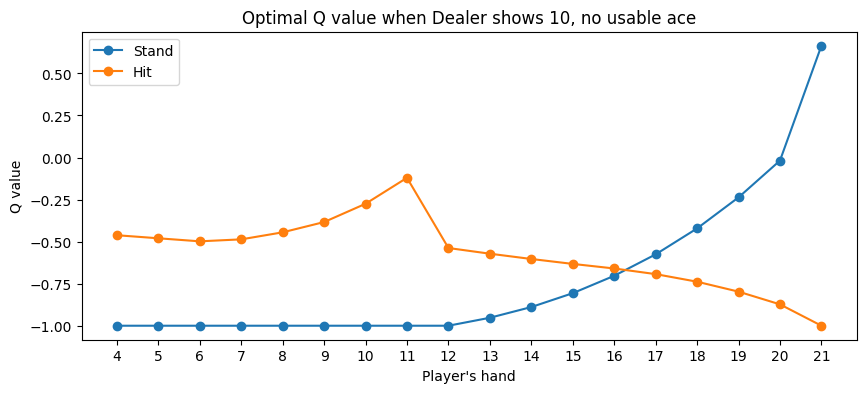

In [ ]:
# Plot some of the Q-values for comparison
V0 = r0 + g*P0.dot(V)
V1 = r1 + g*P1.dot(V)

dealer_card = 10
idx_l = (4-2) + 18*0 + (dealer_card-2)*36
idx_u = (21-2) + 18*0 + (dealer_card-2)*36 + 1

plt.figure(figsize=(10,4))
l0, = plt.plot(V0[idx_l:idx_u], 'o-')
l1, = plt.plot(V1[idx_l:idx_u], 'o-')
plt.xticks(range(0,18), range(4,22))
plt.title("Optimal Q value when Dealer shows 10, no usable ace")
plt.xlabel("Player's hand")
plt.ylabel("Q value")
plt.legend([l0, l1], ["Stand", "Hit"], loc="upper left")
plt.show()

These $Q$ values look as expected. In particular:
- After we stand, the dealer plays their entire hand and the game ends. If we stand at 12 or below we are guaranteed to lose since the dealer can always produce a hand with value at or above 12 without going over 21. This is consistent with the $Q$ value of -1 we see for all hands at or below 12 when we stand.
- Beyond 12, the likelihood of winning when we stand increases as the value of our hand increases. This is consistent with the $Q$ values we see for all hands above 12 when we stand.
- Up to a hand value of 11, the chance of winning increases as the value of our hand increases when we choose to hit. This is because we will never go over 21 when we hit with a hand value at or below 11.
- The chance of winning sharply drops off if we choose to hit with a hand of 12. This is because being dealt a card of value 10 (which can happen with either 10, J, Q, or K) brings our hand value over 21. 12 is the first hand value where we can go over 21 after being dealt a single card.
- The chance of winning when we hit steadily decreases as the value of our hand increases for hand values over 12. This makes sense, since the chance of going over 21 increases as our hand value increases.
- The hand value where $Q(s, 1)$ first exceeds $Q(s, 0)$ is 17. This means that when the dealer is showing a card of value 10, we should hit up to 17 then stand if we do not have a useable ace.

---
### Tabular Q-learning

Now we will find a policy using Q-learning. Unlike the MDP approach above, we do not need to build a model prior to computing a policy. In fact, we only use minimal knowledge of the state space to set up and compute the policy. Instead, the Q-learning algorithm learns an estimate of the optimal Q-function by interacting directly with the environment. The algorithm implemented below can be used with little modification to compute policies for other finite-state, finite-action problems.

In the implementation below, we will play 500K hands of Blackjack to learn our Q-function and the associated policy.

In [ ]:
# Create the Blackjack environment
env = gym.make("Blackjack-v1", render_mode="rgb_array")

# Number of hands/episodes we will play
n_games = 500000

g = 0.98 # Discount factor
a = 0.05 # Learning rate (i.e., smoothing factor)
e = 0.05 # epsilon for epsilon-greedy policy

# Initialize the terminal Q values to zero
Q = {}
Q[("win", 0)] = 0
Q[("win", 1)] = 0
Q[("lose", 0)] = 0
Q[("lose", 1)] = 0

# Loop over all hands/episodes
for i in range(n_games):

    # Print a status update, since this can take a while
    if i%1000 == 0:
        print(f"\r{i} games played...", end="")

    # Initialize the environment and set the initial state
    # If this is the first time we have seen this state
    # add it to the Q table and initialize value to zero
    obs = env.reset()[0]
    if (obs, 0) not in Q:
        Q[(obs, 0)] = 0.0
    if (obs, 1) not in Q:
        Q[(obs, 1)] = 0.0

    # Loop over all turns in the current hand
    done = False
    while done is False:

        # Select an action using epsilon-greedy
        # With some small probability, select a random action...
        if random.random() < e:
            action = env.action_space.sample()
        # otherwise, select the action with greatest Q value
        elif Q[(obs, 0)] > Q[(obs, 1)]:
            action = 0
        else:
            action = 1

        # Apply the selected action and update the state
        obs_prev = obs
        obs, reward, done, truncated, info = env.step(action)
        # Gymnasium does not automatically set obs to a terminal state
        # If the episode is done, set `obs` to the appropriate terminal state
        if done:
            if reward > 0:
                obs = "win"
            else:
                obs = "lose"

        # If this is the first time we have seen the current state
        # add it to the Q table and initialize value to zero
        if (obs, 0) not in Q:
            Q[(obs, 0)] = 0.0
        if (obs, 1) not in Q:
            Q[(obs, 1)] = 0.0

        # Perform the Q update
        maxQ = max(Q[(obs, 0)], Q[(obs, 1)])
        Q[(obs_prev, action)] = (1-a)*Q[(obs_prev, action)] + a*(reward + g*maxQ)

# Close the environment when finished
env.close()

499000 games played...

As we did with the MDP, we can extract a policy from the learned $Q$ function as:
$$
\mu(s) = \text{arg}\max_a \left\{ Q(s,a) \right\}
$$
Here we will obtain and simulate this policy.

In [ ]:
def Q_policy(state, Q):
    """
    This function will implement the learned policy. We will
    pass this to the similator to estimate the win probability.

    Aside from the state, we also take the Q table as a keyword argument.
    """

    # If the current state is not in the Q table, select a random action
    if (state, 0) not in Q:
        return env.action_space.sample()
    # otherwise, select the action with maximum Q value
    elif Q[(state, 0)] > Q[(state, 1)]:
        return 0
    else:
        return 1

In [ ]:
# Simulate the learned policy for 50K hands
run_simulation(50000, Q_policy, Q=Q)

0.42808

Like the policy we computed from the MDP, the policy computed from Q-learning also wins ~41-42% of hands.

**NOTE:** Interestingly, it seems that the policy we learned from Q-learning performs slightly better than the MDP policy. In principle the MDP policy should be optimal, but this is likely because there is a slight mismatch somewhere between my MDP model and the actual behavior of the Gymnasium Blackjack environment (for example, I believe ties are handled differently). This raises another interesting point; the policy we obtain from the MDP model is only as good as the model we use to compute the policy. If the model is inaccurate, the policy might be suboptimal. On the other hand, Q-learning learns its policy from interaction with the actual environment, so an accurate model of the environment is built into the solution.

As a sanity check, we can plot and inspect the learned Q values and compare to those computed by the MDP approach. Again, we will look at the $Q$ values for all the different hands that the player could hold in the case where the dealer's upturned card is a 10 and the player does not have a useable ace.

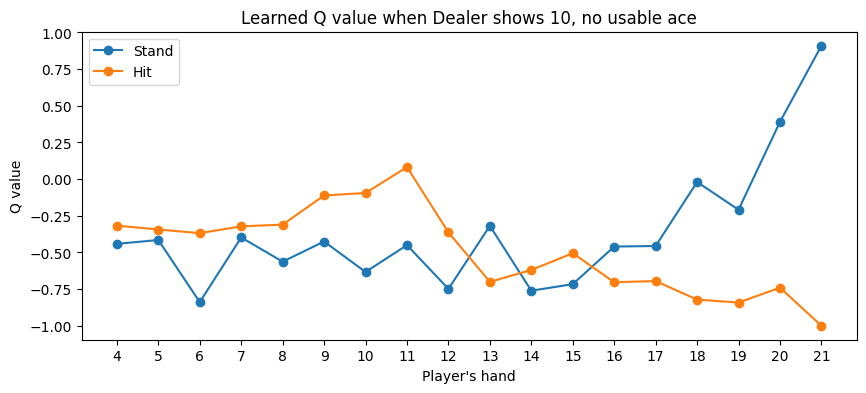

In [ ]:
# Plot some of the Q-values for comparison
V_0 = []
V_1 = []
x = range(4,22)
for i in x:
    V_0.append( Q[((i, 10, 0), 0)] )
    V_1.append( Q[((i, 10, 0), 1)] )

plt.figure(figsize=(10,4))
l0, = plt.plot(x, V_0, 'o-')
l1, = plt.plot(x, V_1, 'o-')
plt.xticks(x, x)
plt.title("Learned Q value when Dealer shows 10, no usable ace")
plt.xlabel("Player's hand")
plt.ylabel("Q value")
plt.legend([l0, l1], ["Stand", "Hit"], loc="upper left")
plt.show()

These $Q$ values should look like a noisy version of the $Q$ values we saw previously (although results can vary due to randomness in the learning procedure). Specifically, we should see:
- A steady increase in the $Q$ values associated with standing for hand values above 12.
- A peak in the $Q$ values associated with hitting at a hand value of 11.
- A steady decrease in the $Q$ values associated with hitting for hand values above 11.
- The values of $Q(s, 1)$ crossing those of $Q(s, 0)$ at 17. This should lead to the same policy we saw for the MDP in this case. That is, we should hit up to 17 then stand if we do not have a useable ace.

---
### Deep Q-learning with Experience Replay

Now we will find a policy using Deep Q-learning. Instead of learning individual Q values in a table, we will learn a neural network with a single hidden layer for the Q function.

As before, we will play 500K hands of Blackjack to learn our Q-function and the associated policy.

In [ ]:
# If we have a GPU we will use it
if torch.cuda.is_available():
  DEVICE = "cuda"
else:
  DEVICE = "cpu"
print(DEVICE)

cpu


In [ ]:
class DQN(torch.nn.Module):
    """
    This class contains a PyTorch implementation of the
    neural network used for our Q function. The network
    contains a single hidden layer with ReLU activations.

    The network takes the state vector as input and returns
    a vector with dimension equal to the size of the action space.
    Each element of this vector contains to the Q value associated
    with the corresponding vector.
    """

    def __init__(self, state_size, action_size):
        """
        Constructor for the Q network, This takes the following parameters:
        - state_size: The dimension of the input states.
        - action_size: The number of distinct actions.
        """
        super(DQN, self).__init__()
        # Create the two linear layers
        self.hidden = torch.nn.Linear(state_size, 50)
        self.linear_q = torch.nn.Linear(50, action_size)
        # Initialize weights to small random values
        torch.nn.init.normal_(self.hidden.weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(self.hidden.bias, mean=0.0, std=0.1)
        torch.nn.init.normal_(self.linear_q.weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(self.linear_q.bias, mean=0.0, std=0.1)

    def evaluate_q(self, state):
        """
        This method produces a vector of Q values given the input state.
        Each element of the vector contains the Q-value for an action.

        A batch of states can be provided as input, and a batch of Q-values
        is returned.
        """
        h = F.relu(self.hidden(state))
        return self.linear_q(h)

    def policy(self, state):
        """
        This method is used to obtain the Q-maximizing action for a
        given state. The function returns the index of the action as well
        as the maximum Q-value.

        A batch of states can be provided as input, and a batch of actions
        and batch of values is returned.
        """
        max_values = self.evaluate_q(state).max(axis=1)
        return (max_values.indices, max_values.values)

    def forward(self, state, action=None):
        """
        This method provides the Q value for a given state and action.
        This is the method that will be evaluated when optimizing the
        model's parameters.
        """
        return self.evaluate_q(state).gather(1, action.view(-1,1))

In [ ]:
class ExperienceReplayBuffer:
    """
    This class implements the experience replay buffer that will
    store a history that is sampled when training.
    """

    def __init__(self, capacity):
        """
        Constructor for the Experience Replay Buffer. This takes
        the following parameters:
        - capacity: The maximum number of items to store in the buffer.
        """
        # Use a double-ended queue for the buffer
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        This method pushes a new item into the buffer. If the buffer is
        at capacity, the oldest item in the buffer will be evicted.
        """
        self.memory.append([state, action, reward, next_state, done])

    def sample(self, batch_size):
        """
        This method samples batch_size items randomly from the buffer.
        Items are sampled with replacement.
        """
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

In [ ]:
class DeepQLearner:
    """
    This class implements our learner object. This object is used to configure
    then run training on the Blackjack environment.
    """

    def __init__(self, state_size=3, action_size=2, epsilon=0.05, a=0.05, g=0.98):
        """
        Constructor for the Learner. This takes the following parameters:
        - state_size: dimension of the state space.
        - action_size: number of distinct actions.
        - epsilon: Probability of choosing a random action in epsilon-greedy.
        - a: Learning rate alpha for Q-learning.
        - g: Discount factor gamma for discounted reward.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.a = a
        self.g = g
        # Initialize the Q network and replay buffer
        self.dqn = DQN(state_size, action_size).to(DEVICE)
        self.replay_buffer = ExperienceReplayBuffer(10000)

        # Set up the loss function for training. We will use mean square error.
        self.loss_fn = torch.nn.MSELoss()
        # Set up the optimizer. We will use stochastic gradient descent
        # with a learning rate of 1e-3.
        self.optimizer = torch.optim.SGD(self.dqn.parameters(), lr=1e-3)

    def get_action(self, state):
        """
        This method is used to select actions given the state during
        training. The epsilon-greedy policy is used.
        """
        # Select a random action with probability epsilon
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        # Otherwise select the Q-maximizing action
        else:
            action = self.dqn.policy(
                state=torch.tensor([state], dtype=torch.float32).to(DEVICE)
            )[0].item()
            return action

    def compute_targets(self, states, actions, rewards, next_states, dones):
        """
        This method is used to compute the target Q values that we will
        try to match when updating the Q-network's parameters. Batches of
        states, actions, rewards, next states, and boolean values indicating
        whether an episode is complete are provided as inputs.
        """

        # Evalute Q for the current states and actions
        Q = self.dqn(
            state=torch.tensor(states, dtype=torch.float32).to(DEVICE),
            action=torch.tensor(actions, dtype=torch.int64).to(DEVICE)
        )

        # Get the maximum Q values over all actions for the next states
        Q_max = self.dqn.policy(
            state=torch.tensor(next_states, dtype=torch.float32).to(DEVICE)
        )[1].view(-1,1)
        # If an episode has ended, the next Q values is zero
        # We multiply the Q_max tensor by a mask to enforce this
        done_mask = (1-torch.tensor(dones, dtype=torch.int64).view(-1,1)).to(DEVICE)
        Q_max = Q_max*done_mask

        # Get the tensor of rewards
        r = torch.tensor(rewards, dtype=torch.float32).view(-1,1).to(DEVICE)

        # Compute the targets
        targets = (1-self.a)*Q + self.a*(r + self.g*Q_max)

        # Return targets. Ensure these are treated as constant when optimizing.
        return targets.detach()

    def update_q_model(self, batch, targets, n_iters=20):
        """
        This method updates the parameters of the Q network to reduce MSE
        between the Q values on a sampled batch and the targets. This takes the
        following parameters:
        - batch: A dictionary containing tensors of states and actions.
        - targets: A tensor of target values to match.
        - n_iters: The number of steps of stochastic gradient descent to perform.
        """

        # Perform n_iters iterations of SGD
        for i in range(n_iters):
            loss = self.loss_fn(self.dqn(**batch), targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Return the loss, in case we want to track this
        return loss.item()

    def train(self, n_steps, batch_size):
        """
        This method launches training of the Q network. This takes the following
        parameters:
        - n_steps: The number of hands of Blackjack to play.
        - batch_size: The size of the batches we will sample from the replay buffer.
        """

        # Create the Blackjack environment
        env = gym.make("Blackjack-v1", render_mode="rgb_array")

        # Initially populate the replay buffer with one batch.
        state = env.reset()[0]
        for i in range(batch_size):
            # Get an action, apply it to the environment, and push the result
            # to the replay buffer
            action = self.get_action(state)
            next_state, reward, done, info, other = env.step(action)
            self.replay_buffer.push(state, action, reward, next_state, done)
            # If the episode is over, initialize a new episode
            if done:
                state = env.reset()[0]
            else:
                state = next_state

        # Iterate over hands and update the Q function
        for i in range(n_steps):

            # Every 1000 steps print an update
            if i%1000 == 0:
                print(f"\r{i} steps...", end="")

            # Sample a batch from the buffer and compute the targets
            states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
            targets = self.compute_targets(states, actions, rewards, next_states, dones)

            # Update model to match targets on the sampled batch
            batch_in = {
                "state": torch.tensor(states, dtype=torch.float32).to(DEVICE),
                "action": torch.tensor(actions, dtype=torch.int64).to(DEVICE)
            }
            loss_value = self.update_q_model(batch_in, targets)

            # Get an action, apply it to the environment, and push the result
            # to the replay buffer
            action = self.get_action(state)
            next_state, reward, done, info, other = env.step(action)
            self.replay_buffer.push(state, action, reward, next_state, done)
            # If the episode is over, initialize a new episode
            if done:
                state = env.reset()[0]
            else:
                state = next_state

        # Close the Blackjack environment
        env.close()

In [ ]:
# Create a new learner object and train the deep Q network
learner = DeepQLearner(3,2)
learner.train(500000, 200)

499000 steps...

As with the tabular Q-learning, we can extract a policy from the learned $Q$ function as:
$$
\mu(s) = \text{arg}\max_a \left\{ Q(s,a) \right\}
$$
Here we will obtain and simulate this policy.

In [ ]:
def deep_Q_policy(state, dqn):
    """
    This function will implement the learned policy from deep Q learning.
    We will pass this to the simulator to estimate the win probability.

    Aside from the state, we also take the neural network as a keyword argument.
    """

    # Use the "policy" method of the network to get an action
    action = dqn.policy(
        state=torch.tensor([state], dtype=torch.float32).to(DEVICE)
    )[0].item()

    return action

In [ ]:
run_simulation(50000, deep_Q_policy, dqn=learner.dqn)

0.42172

Like the policy we computed from the MDP, the policy computed from Deep Q-learning also wins ~41-42% of hands.

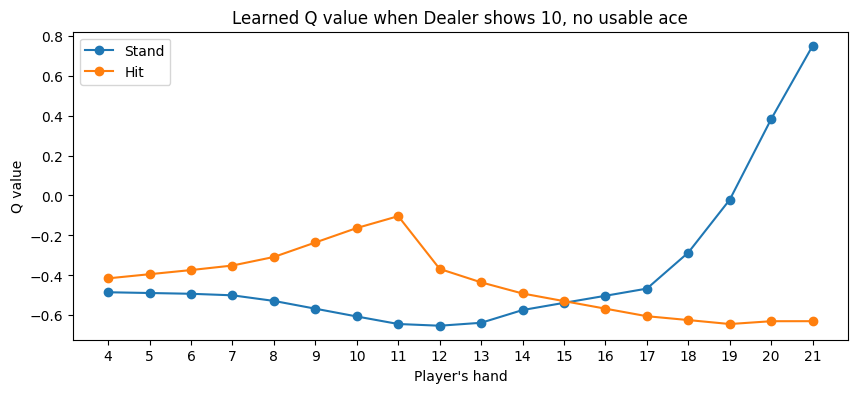

In [ ]:
# Plot some of the Q-values for comparison
V_0 = []
V_1 = []
x = range(4,22)
for i in x:
    V_0.append(
        learner.dqn(
            state=torch.tensor([[i,10,0]], dtype=torch.float32).to(DEVICE),
            action=torch.tensor([[0]], dtype=torch.int64).to(DEVICE)
        ).item()
    )
    V_1.append(
        learner.dqn(
            state=torch.tensor([[i,10,0]], dtype=torch.float32).to(DEVICE),
            action=torch.tensor([[1]], dtype=torch.int64).to(DEVICE)
        ).item()
    )

plt.figure(figsize=(10,4))
l0, = plt.plot(x, V_0, 'o-')
l1, = plt.plot(x, V_1, 'o-')
plt.xticks(x, x)
plt.title("Learned Q value when Dealer shows 10, no usable ace")
plt.xlabel("Player's hand")
plt.ylabel("Q value")
plt.legend([l0, l1], ["Stand", "Hit"], loc="upper left")
plt.show()

These $Q$ values also look like $Q$ values we saw previously for the MDP solution. These values are considerably less noisy than the ones we computed from tabular Q-learning, since we are no longer independently estimating values of $Q(s,a)$ for each state and action.

---
---
##Appendix

Here we provide pre-trained weights for a neural network learned from Deep Q-learning. Training on 500K steps as above can be slow. These weights can be loaded, then we can test performance of the policy and plot Q values.

In [ ]:
dqn_state_dict = OrderedDict([("hidden.weight",
              torch.tensor([[ 0.0434,  0.0016,  0.0162],
                      [-0.0061, -0.0192, -0.1346],
                      [ 0.0939, -0.0290,  0.0470],
                      [ 0.0417, -0.4438, -0.2077],
                      [-0.0063,  0.1771,  0.1946],
                      [ 0.2241, -0.2998,  0.1446],
                      [-0.0194,  0.2161,  0.0389],
                      [-0.1946,  0.2332, -0.1415],
                      [ 0.2643, -0.0046, -0.2054],
                      [ 0.0987,  0.0680,  0.0869],
                      [ 0.1369, -0.2605, -0.0532],
                      [-0.1447,  0.0642,  0.0463],
                      [ 0.0398, -0.0248,  0.2240],
                      [-0.3306,  0.3584,  0.0793],
                      [ 0.0852, -0.1315, -0.0472],
                      [-0.1306, -0.0358, -0.0068],
                      [-0.0065, -0.0119,  0.0196],
                      [-0.1240,  0.0219, -0.0130],
                      [-0.0747,  0.0743, -0.0874],
                      [-0.3387,  0.4201, -0.0806],
                      [ 0.0031, -0.0705, -0.0523],
                      [ 0.1228, -0.3557, -0.1296],
                      [ 0.0898, -0.0840,  0.1311],
                      [-0.1180, -0.0180, -0.0979],
                      [ 0.1171, -0.2893,  0.1725],
                      [-0.1405,  0.0457,  0.0218],
                      [-0.1379, -0.0615, -0.0033],
                      [-0.0039,  0.0046, -0.0857],
                      [-0.1053, -0.1814, -0.1796],
                      [-0.1168,  0.0590,  0.0105],
                      [-0.0377, -0.1080,  0.0755],
                      [-0.1911, -0.0802, -0.0070],
                      [ 0.0930, -0.1654,  0.1103],
                      [ 0.0353, -0.0955,  0.0332],
                      [ 0.1345, -0.1188,  0.2337],
                      [ 0.1155,  0.1993,  0.2840],
                      [ 0.0700,  0.2295, -0.0866],
                      [ 0.0960,  0.1057,  0.0541],
                      [-0.0403, -0.0383, -0.1602],
                      [-0.0583, -0.0125, -0.0332],
                      [ 0.1747, -0.2589,  0.0282],
                      [ 0.2271, -0.3754,  0.0367],
                      [-0.0392,  0.4809,  0.0163],
                      [-0.0948, -0.0123,  0.0955],
                      [ 0.1764, -0.4161, -0.0500],
                      [-0.3106,  0.0039, -0.0390],
                      [-0.1093, -0.0226, -0.0308],
                      [ 0.3531, -0.3629, -0.0009],
                      [-0.0658,  0.0134,  0.0022],
                      [-0.0567, -0.0161, -0.0666]])),
             ("hidden.bias",
              torch.tensor([-0.7531, -0.0625,  0.0632,  0.2029, -0.0349, -0.9172, -0.0163,  0.1942,
                      -0.1905, -0.1183,  0.1441, -0.0632,  0.2004,  0.0405,  0.2520,  0.0225,
                      -0.0294, -0.0333, -0.1670, -0.1242,  0.0050,  0.1786,  0.2291,  0.0872,
                      -0.0463,  0.1045,  0.0461,  0.1695, -0.0927, -0.1232, -0.0241, -0.1374,
                       0.3498,  0.2173,  0.1513, -0.1387, -0.2104, -0.1876,  0.1675, -0.1599,
                       0.4701, -0.5429, -0.1046,  0.0203,  0.5176, -0.0563, -0.0216, -0.2408,
                       0.1297,  0.2177])),
             ("linear_q.weight",
              torch.tensor([[ 0.7203,  0.2259, -0.0450, -0.4391, -0.1511,  0.9669, -0.1912,  0.3407,
                        0.2057,  0.1778, -0.2230, -0.1056, -0.2020, -0.0140, -0.2404,  0.1562,
                        0.1261, -0.0197,  0.0111,  0.3091, -0.1351, -0.1931, -0.2192, -0.0675,
                       -0.3738,  0.0072,  0.0734, -0.1904, -0.1266, -0.0305, -0.0640, -0.1793,
                       -0.3050, -0.2011, -0.1207,  0.2945,  0.3012,  0.2556, -0.1045,  0.1206,
                       -0.4473,  0.6643, -0.4760, -0.1401, -0.5944,  0.0145,  0.0039,  0.0990,
                       -0.1332, -0.1645],
                      [ 0.0603, -0.0049,  0.0796, -0.1173,  0.1113,  0.1377, -0.0880, -0.0249,
                       -0.1644,  0.0925, -0.1348,  0.1973,  0.3683, -0.4662,  0.0810, -0.0418,
                       -0.0238,  0.0453,  0.0468,  0.4369,  0.2858, -0.3521,  0.1106,  0.0765,
                        0.1563,  0.1540, -0.1606, -0.0802,  0.0513, -0.0349, -0.0784,  0.0690,
                        0.1934, -0.0845,  0.2844,  0.2665, -0.1291, -0.0613, -0.0695, -0.0200,
                        0.3339,  0.1623, -0.2110, -0.0070, -0.2240,  0.1720,  0.0932, -0.5167,
                        0.0915,  0.0417]])),
             ("linear_q.bias", torch.tensor([-1.0599,  0.2251]))])

In [ ]:
learner = DeepQLearner(3,2)
learner.dqn.load_state_dict(dqn_state_dict)

<All keys matched successfully>